In [1]:
# Calculate the densimetric Froude number for the upper layer
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
Data = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_010.nc')
xdis = Data.X.data
gh = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) # Grid height

In [18]:
def Froude(Hs):
    file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(Hs,'03d')) + '.nc')
    grid = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(Hs,'03d')) + '.nc')
    state = file.isel(Y=range(1,10), T=range(40,len(file.T)))
    depth = state.Z.data
    drF = grid.drF.data # r cell face separation
    pres = gsw.p_from_z(depth, 0)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    p = np.tile(pres,[len(xdis),1]).T
    rho = gsw.rho(s, pt, p)
    
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_x = (u0[:, :, :, 1:] + u0[:, :, :, :-1]) / 2 # Convert the value to grid center in x direction
    u = u_x.mean(axis=(0,2)) # dims = Z, X
    #u[u==0] = np.nan
       
    Fr1 = np.empty(len(xdis))
    Fr2 = np.empty(len(xdis))
    U1 = np.empty(len(xdis))
    H1 = np.empty(len(xdis))
    Gr = np.empty(len(xdis))
    Fr1[[0,-1]] = np.nan
    Fr2[[0,-1]] = np.nan
    U1[[0,-1]] = np.nan
    H1[[0,-1]] = np.nan
    Gr[[0,-1]] = np.nan
    for i in range(1,len(xdis)-1):           
        p = np.where(u[:,i] < 0)[-1][0]
        gh = grid.HFacC.data[:,1:10,i].mean(1) * drF
        h1 = gh[:p].sum()
        u1 = np.sum(u[:p,i] * gh[:p] / h1) 
        rho1 = np.sum(rho[:p,i] * gh[:p] / h1)
        
        if sum(j < 0 for j in u[p:,i]) == len(gh)-p:
            n = len(gh) - p
        else:    
            n = np.where(u[p:,i] >= 0)[-1][0]
            
        h2 = gh[p:p+n].sum()
        u2 = np.sum(u[p:p+n,i] * gh[p:p+n] / h2)
        rho2 = np.sum(rho[p:p+n,i] * gh[p:p+n] / h2)
            
        g = 9.8 * (rho2-rho1) / rho2
        Fr1[i] = u1 ** 2 / (g * h1)
        Fr2[i] = u2 ** 2 / (g * h2)
        U1[i] = u1
        H1[i] = h1
        Gr[i] = g
    return (U1, H1, Gr, Fr1)

In [28]:
Hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30])
r = Hs / 150

#u1, h1, g, Fr1 = Froude(Hs[2])

Text(0.5, 0, '$\\frac{H_s}{H}$')

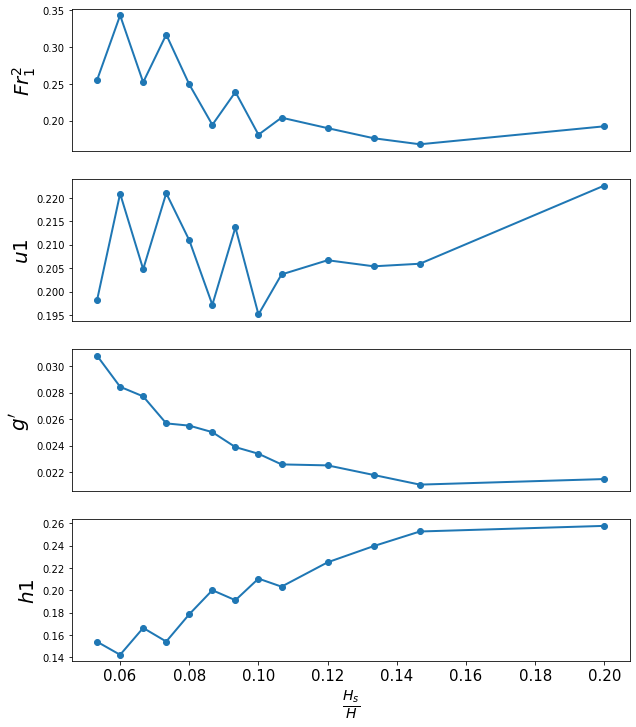

In [62]:
#fig1, ax =plt.subplots(figsize=(10,7))

U = np.empty(len(r))
G = np.empty(len(r))
H = np.empty(len(r))
Fr = np.empty(len(r))

for j in range(len(Hs)):
    u1, h1, g, Fr1 = Froude(Hs[j])
    U[j] = u1[65] 
    G[j] = g[65]
    H[j] = h1[65]
    Fr[j] = Fr1[65]


# Make plots
fig1 = plt.figure(figsize=(10,12))
#fig.tight_layout()
ax1 = fig1.add_subplot(411)
ax1.plot(r,Fr,'o-',linewidth=2)
plt.ylabel('$Fr^2_1$', size=20)
ax1.axes.get_xaxis().set_visible(False)
#ax1.tick_params(axis='y', labelsize=15)


ax2 = fig1.add_subplot(412)
ax2.plot(r,U,'o-',linewidth=2)
plt.ylabel('$u1$', size=20)
ax2.axes.get_xaxis().set_visible(False)
#ax2.tick_params(axis='y', labelsize=15)


ax3 = fig1.add_subplot(413)
ax3.plot(r,G,'o-',linewidth=2)
plt.ylabel('$g\'$', size=20)
ax3.axes.get_xaxis().set_visible(False)
#ax3.tick_params(axis='y', labelsize=15)


ax4 = fig1.add_subplot(414)
ax4.plot(r,G*H,'o-',linewidth=2)
plt.ylabel('$h1$', size=20)
#ax4.tick_params(axis='y', labelsize=15)
ax4.tick_params(axis='x', labelsize=15)
ax4.set_xlabel(r'$\frac{H_s}{H}$', size=20)


Text(0.5, 0, '$\\frac{H_s}{H}$')

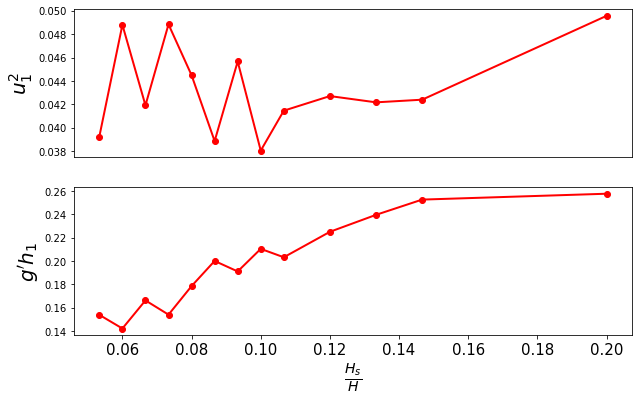

In [64]:
fig2 = plt.figure(figsize=(10,6))
#fig.tight_layout()
ax1 = fig2.add_subplot(211)
ax1.plot(r,U**2,'o-r',linewidth=2)
plt.ylabel('$u^2_1$', size=20)
ax1.axes.get_xaxis().set_visible(False)


ax2 = fig2.add_subplot(212)
ax2.plot(r,G*H,'o-r',linewidth=2)
plt.ylabel('$g\'h_1$', size=20)
#ax4.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel(r'$\frac{H_s}{H}$', size=20)

In [65]:
fig_path = "/Users/weiyangbao/Documents/Model_outputs/Froude/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/Fr1_values.png', dpi = 150, bbox_inches='tight')